CS677-004 Deep Learning 

Programming Assignment 2

Topic: Transportation mode classification using CNN

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.3.0


In [4]:
data = pd.read_csv('/content/drive/My Drive/CS677/Programming Assignment 2/data.csv', header=None)

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
0,2.3630,2.0779,2.0059,1.8738,2.4091,2.7567,3.06160,3.2438,3.5714,3.4489,3.4149,3.0607,3.3529,3.4739,3.6257,3.7866,4.1557,4.0827,4.0132,3.6466,3.0099,2.4859,2.0213,1.4998,1.2414,1.1377,1.0624,1.3115,1.7967,2.1816,2.7634,3.4696,4.2004,4.7987,5.0522,4.7985,4.3834,4.0134,3.4752,2.9479,...,5.3061,4.6004,3.9951,3.3981,2.7250,2.6336,2.7379,2.4321,2.0255,1.8441,1.7177,1.7344,1.8481,1.8572,1.9347,1.9470,1.8401,1.6534,1.6553,1.5893,1.4814,1.3621,1.58450,2.04950,2.58400,2.8410,3.2619,3.4649,3.1260,2.7496,2.4973,2.7431,3.0460,3.5700,4.0879,4.7550,4.5093,4.0592,3.6183,0
1,3.3351,3.8362,3.9755,4.3974,4.3581,4.8556,4.33880,4.2298,3.9837,3.8393,3.2790,2.7431,2.1119,1.7562,1.6227,1.6901,1.6920,1.8352,2.0380,2.1356,2.6559,3.5131,4.4236,5.1298,5.6037,5.3061,4.6004,3.9951,3.3981,2.7250,2.6336,2.7379,2.4321,2.0255,1.8441,1.7177,1.7344,1.8481,1.8572,1.9347,...,1.7264,1.5377,1.6122,1.8658,1.8218,1.6876,1.7552,1.7617,1.7515,1.8736,1.9472,1.8389,1.7975,1.9404,2.3188,3.0621,3.3923,3.3859,3.7074,3.7011,3.3150,3.4839,3.97570,4.02850,4.18510,4.3807,4.0930,3.5671,2.9868,2.3359,1.6718,1.4243,1.5971,1.6985,1.8106,1.9223,1.9805,1.9841,2.2742,0
2,2.9888,2.2007,1.5232,1.2309,1.1879,1.0139,0.82491,1.3230,2.0033,2.6067,3.4173,4.3156,4.6136,4.4431,4.2084,4.1017,4.1192,4.0010,3.6551,3.3508,3.0509,2.6722,2.2802,2.0488,1.8762,1.7264,1.5377,1.6122,1.8658,1.8218,1.6876,1.7552,1.7617,1.7515,1.8736,1.9472,1.8389,1.7975,1.9404,2.3188,...,1.6749,1.6750,1.9850,2.3529,2.7056,3.1522,3.4378,3.4077,3.5126,3.3150,3.1979,3.2256,3.4095,3.4915,3.8555,3.7350,3.4905,3.1630,2.7132,2.0700,1.6002,1.2203,0.92127,0.78088,0.90382,1.3752,2.0166,2.6460,3.1065,3.6137,3.8819,3.9583,3.9145,4.1136,4.3393,3.9726,3.5225,3.6245,3.1923,0
3,2.7536,3.4015,4.0295,4.4294,4.5497,4.4177,4.09180,3.8896,3.6138,3.0180,2.6134,2.2989,1.7815,1.3916,1.5243,1.4783,1.5184,1.6710,1.4866,1.3976,1.6634,1.7063,1.5138,1.6874,1.7295,1.6749,1.6750,1.9850,2.3529,2.7056,3.1522,3.4378,3.4077,3.5126,3.3150,3.1979,3.2256,3.4095,3.4915,3.8555,...,3.9320,4.4306,4.7756,5.0455,4.6569,4.3694,3.7538,2.8815,2.3253,2.0091,1.7491,1.4590,1.6394,1.9035,2.5358,3.2687,4.1206,4.7709,5.0287,4.9990,5.0543,4.8308,4.48990,4.12130,3.63620,2.8954,2.4679,2.1420,1.9152,1.6305,1.6182,1.6513,1.4662,1.3964,1.3607,1.3314,1.2890,1.6128,1.7203,0
4,2.4033,2.2425,2.3487,1.9880,1.8548,1.9522,1.95860,1.8108,1.6193,1.4585,1.3875,1.2306,1.2359,1.4657,1.8516,1.9066,2.5636,3.3693,4.0764,4.2700,4.4251,4.1178,3.6478,3.2564,3.5896,3.9320,4.4306,4.7756,5.0455,4.6569,4.3694,3.7538,2.8815,2.3253,2.0091,1.7491,1.4590,1.6394,1.9035,2.5358,...,3.3252,3.7527,4.0025,4.4005,5.3609,6.0200,5.6337,4.9674,4.1698,2.8144,1.9173,1.8026,1.8074,1.7450,1.9072,2.0633,2.1482,2.2176,2.1179,1.9391,2.0517,2.1875,2.29680,2.48630,2.70840,2.5567,2.5436,2.8319,3.7025,4.1852,4.2846,4.4212,4.4358,4.1614,4.3205,4.5931,4.9707,4.9617,4.3099,0


In [6]:
y = data.iloc[:,-1]
print(y.shape)

(21000,)


In [7]:
X = data.iloc[:,0:-1]
print(X.shape)

(21000, 128)


In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = [x for x in range(0,128)])
scaled_X['label'] = y.values

scaled_X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,label
0,0.445118,0.321433,0.295783,0.237726,0.468458,0.619155,0.751973,0.830488,0.976231,0.923527,0.911790,0.756207,0.882692,0.940135,1.010668,1.072244,1.240645,1.218492,1.194208,1.030930,0.754353,0.518841,0.308902,0.080410,-0.031659,-0.077286,-0.110253,-0.003967,0.204737,0.368561,0.617504,0.921523,1.240204,1.492964,1.608907,1.499361,1.323238,1.157557,0.924357,0.697179,...,1.715415,1.406436,1.150284,0.894267,0.601780,0.561622,0.607030,0.478375,0.302105,0.226878,0.172356,0.180247,0.226748,0.230083,0.262507,0.269903,0.222516,0.143662,0.146015,0.119388,0.072907,0.022683,0.120864,0.324772,0.557011,0.664630,0.848194,0.933856,0.780437,0.615401,0.505612,0.609698,0.739944,0.969423,1.200159,1.497063,1.381863,1.185769,0.989700,0
1,0.861563,1.072605,1.146364,1.324369,1.307680,1.523006,1.302609,1.255439,1.154596,1.092441,0.852842,0.618797,0.345712,0.193602,0.136917,0.163434,0.166408,0.232004,0.323378,0.365833,0.598049,0.970331,1.353826,1.648485,1.849556,1.715996,1.407221,1.151013,0.894847,0.602112,0.561822,0.607369,0.478701,0.302494,0.227315,0.172770,0.180479,0.226969,0.230219,0.262546,...,0.175821,0.093409,0.125217,0.234233,0.213707,0.155874,0.185245,0.189788,0.184569,0.239569,0.271064,0.225302,0.205012,0.265768,0.427265,0.750751,0.889368,0.890540,1.035622,1.038175,0.870433,0.949797,1.167677,1.190310,1.255962,1.332791,1.209356,0.978208,0.720338,0.437247,0.150920,0.044291,0.119136,0.164400,0.215319,0.265939,0.287957,0.288524,0.411031,0
2,0.713209,0.373895,0.087327,-0.039102,-0.057380,-0.131348,-0.212326,0.002652,0.297858,0.559132,0.912831,1.299140,1.428196,1.361361,1.264854,1.208836,1.224731,1.182631,1.036328,0.900728,0.772456,0.600726,0.421515,0.317565,0.242094,0.175978,0.093607,0.125450,0.234515,0.213921,0.156004,0.185448,0.190000,0.184872,0.240020,0.271593,0.225560,0.205222,0.265913,0.427314,...,0.153671,0.152271,0.285587,0.444050,0.593444,0.784054,0.907434,0.898340,0.940020,0.859666,0.808995,0.823176,0.897501,0.931053,1.086426,1.040915,0.931556,0.794448,0.604626,0.328528,0.124579,-0.039277,-0.169483,-0.230074,-0.176462,0.028537,0.307039,0.578476,0.772018,0.987513,1.100531,1.130688,1.112069,1.203252,1.308879,1.157023,0.954994,0.997810,0.806296,0
3,0.612450,0.886895,1.169685,1.338148,1.390182,1.334433,1.196121,1.108818,0.994574,0.737089,0.564131,0.426614,0.202748,0.035143,0.093993,0.071621,0.090714,0.159932,0.080275,0.040987,0.159825,0.176180,0.088155,0.161448,0.178831,0.153822,0.152496,0.285897,0.444427,0.593774,0.784293,0.907870,0.898835,0.940871,0.860769,0.810144,0.823772,0.898017,0.931350,1.086512,...,1.124428,1.333640,1.486037,1.603879,1.431848,1.306122,1.043064,0.671828,0.430709,0.297861,0.185861,0.061509,0.137094,0.249941,0.520347,0.839840,1.202258,1.487611,1.608419,1.602857,1.626944,1.538322,1.392782,1.230898,1.016343,0.688237,0.503155,0.359754,0.257680,0.133476,0.127890,0.141613,0.063050,0.034452,0.020755,0.009126,-0.011171,0.127979,0.172563,0
4,0.462382,0.391752,0.443823,0.286899,0.229782,0.272713,0.276439,0.212886,0.131736,0.062341,0.032384,-0.035586,-0.033333,0.067347,0.236768,0.257284,0.546448,0.905361,1.222072,1.305332,1.379213,1.236117,1.016378,0.839220,0.980988,1.124846,1.334393,1.486928,1.604781,1.432433,1.306451,1.043544,0.672231,0.431191,0.298374,0.186291,0.061674,0.137275,0.250082,0.520400,...,0.863449,1.043014,1.153468,1.326047,1.734332,2.014080,1.849936,1.569743,1.221936,0.644305,0.258204,0.209652,0.209264,0.181959,0.250711,0.320053,0.354881,0.386888,0.346557,0.271577,0.320960,0.383339,0.432693,0.515811,0.611317,0.541256,0.536051,0.659152,1.029337,1.233622,1.273559,1.329147,1.335429,1.223813,1.300749,1.426700,1.581455,1.575997,1.287451,0


In [9]:
Freq = 50  # frequency
window_size_S = int(Freq*10.24) # 512
hop_size_s = int(Freq*1.28) # 64
print(window_size_S)
print(hop_size_s)

512
64


In [10]:
def get_window(df, window_size_S, hop_size_s):

    N_FEATURES = 128

    frames = []
    labels = []
    for i in range(0, len(df) - window_size_S, hop_size_s):
      m = []
      for col in range(0,128):
        m.append(df[col].values[i: i + window_size_S])
        
      # Retrieve the most often used label in this segment
      label = stats.mode(df['label'][i: i + window_size_S])[0][0]
      frames.append(m)
      labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, window_size_S, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X_windows, label_windows = get_window(scaled_X, window_size_S, hop_size_s)

print(X_windows.shape) 
print(label_windows.shape)

(321, 512, 128)
(321,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_windows, 
                                                    label_windows, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    stratify=label_windows)

In [12]:
print(X_train.shape) 
print(X_test.shape)

(256, 512, 128)
(65, 512, 128)


In [13]:
X_train = X_train.reshape(256, 512, 128, 1)
X_test = X_test.reshape(65, 512, 128, 1)

In [14]:
X_train[0].shape, X_test[0].shape

((512, 128, 1), (512, 128, 1))

In [15]:
model = Sequential()
model.add(Conv2D(16, kernel_size=3,padding = 'same',activation='relu', input_shape=X_train[0].shape))
model.add(MaxPool2D(pool_size=(2)))

model.add(Conv2D(32,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2)))

model.add(Conv2D(32,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2)))

model.add(Conv2D(32,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2)))

model.add(Conv2D(32,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2)))

model.add(Flatten())
model.add(Dense(200, activation='relu'))

model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 128, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 64, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 64, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 32, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 32, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 16, 32)        9

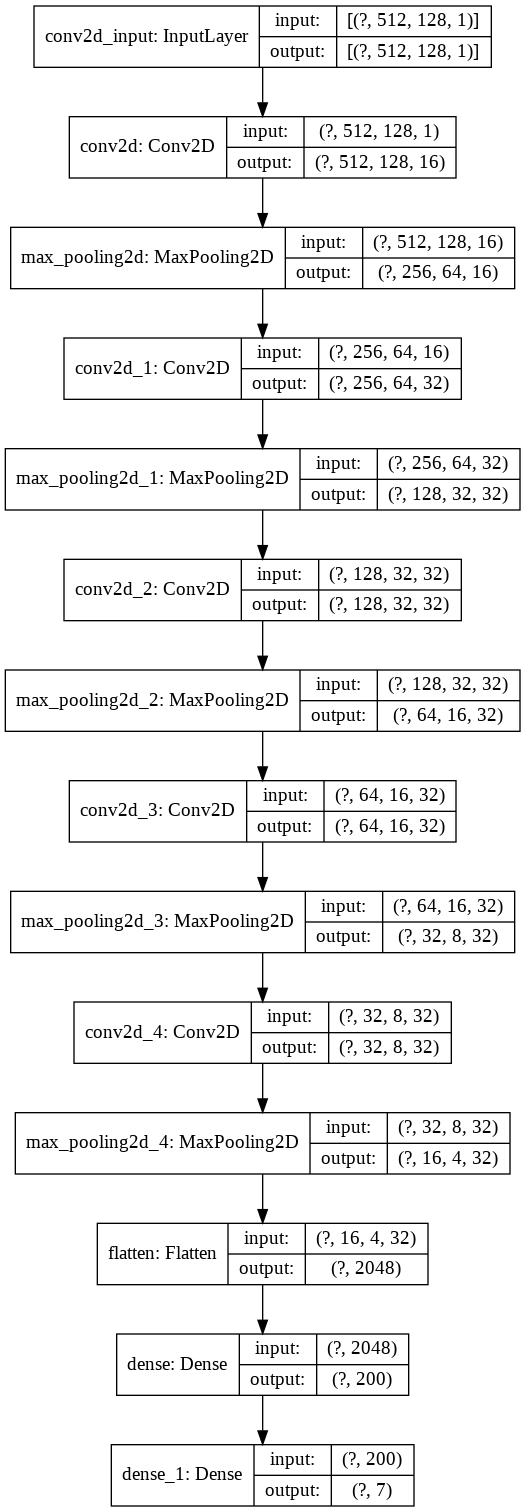

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/CS677/Programming Assignment 2/model.png', show_shapes=True,show_layer_names=True)

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=15, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
    )

In [15]:
model.compile(optimizer=Adam(learning_rate = 0.001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])


history = model.fit(X_train, 
                    y_train, 
                    epochs = 100, 
                    validation_data= (X_test, y_test), 
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
8/8 [==============================] - 0s 59ms/step - loss: 1.6465 - accuracy: 0.2344 - val_loss: 1.4257 - val_accuracy: 0.3231
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 1.3094 - accuracy: 0.3633 - val_loss: 1.3206 - val_accuracy: 0.4462
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 1.2568 - accuracy: 0.4609 - val_loss: 1.2373 - val_accuracy: 0.5846
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 1.1504 - accuracy: 0.5898 - val_loss: 1.1399 - val_accuracy: 0.6154
Epoch 5/100
8/8 [==============================] - 0s 31ms/step - loss: 0.9299 - accuracy: 0.6328 - val_loss: 1.4078 - val_accuracy: 0.5846
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 0.9340 - accuracy: 0.6367 - val_loss: 1.0938 - val_accuracy: 0.6615
Epoch 7/100
8/8 [==============================] - 0s 30ms/step - loss: 0.7116 - accuracy: 0.7031 - val_loss: 0.9299 - val_accuracy: 0.6308
Epoch 8/100
8/8 [===

In [16]:
_, acc = model.evaluate(X_test, y_test, verbose=0)

In [17]:
print(f'Accuracy of the model is {acc*100} %')

Accuracy of the model is 95.38461565971375 %
